# Master Data Science, Lyon 1
# TP2 PGM (durée 6h) 
Compte-rendu COUDERT Rémi-Vinh p1115674

### Demande spéciale

Monsieur, il y avait la correction en cachée dans votre dossier et il y en a pas mal qui ont/vont pomper dessus. Alors, c'est sûr que je l'ai aussi regardé comme les autres mais j'ai beaucoup travaillé entre le tutorial PyTorch et votre correction pour essayer de comprendre le fonctionnement et les subtilités du chatbot. J'y ai passé 17 heures en tout.<br>Tout ça pour vous demander si cela a été utile ou non, est-ce que cela va me différencier de ceux qui ont simplement copié niveau notes ? Je vous avoue que je suis un peu perdu par ce système de notes et de TPs et j'ai juste besoin d'être rassuré par un petit mot de votre part. N'hésitez pas à m'écrire.

# Plan
On construit un chatbot avec un encodeur, un décodeur et un système d'attention.

- La première reconnaissance de mots s'appuie sur un word2index pour l'input_lang et l'output_lang.
- La deuxième reconnaissance de mots s'appuie sur un word2vec entraîné sur la base de données.
- La troisième reconnaissance de mots s'appuie sur le même word2vec entraîné sur la base de données mais permet de reconnaître certains mots inconnus en les associant à des mots similaires du vocabulaire via un word2vec pré-entraîné sur Wikipédia.

# Master Data Science, Lyon 1
# TP2 PGM (durée 6h) 

Alex Aussem (alexandre.aussem@univ-lyon1.fr)

***

## Chatbot with a sequence to sequence network and attention
*************************************************************

In this tutorial, you will learn how to teach a recurrent neural network to anwers various questions about the admission to the master in Data Science of Lyon 1** to varying degrees of success... 

From Siri to Google Translate, deep neural networks have enabled breakthroughs in machine understanding of natural language. Most of these models treat language as a flat sequence of words or characters, and use a kind of model called a recurrent neural network (RNN) to process this sequence

The code was adapated by Alex Aussem from the Pytorch example "Translation with a Sequence to Sequence Network and Attention". **Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

Sentences are in French. Example: [> input, = target, < output]

    
    > pourriez vous me renseigner ?
    = oui volontiers d ou venez vous ?
    < oui volontiers <EOS>

    > quel est le corps professoral ?
    = il est compose de chercheurs du liris 
    < il est compose de chercheurs du liris  <EOS>
    
To deal with these types of variable-length input and output, we need to use a recurrent neural network (RNN). Feed-forward neural networks, such as convolutional neural networks, do not maintain internal state other than the network’s own parameters. An RNN maintains its internal state while reading a sequence of inputs, which in our case will be a sequence of words, thereby being able to process an input of any length.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an **attention mechanism**, which lets the decoder
learn to focus over a specific range of the input sequence. The approach of incorporating attention mechanism has become one of the hottest topics in deep learning recently (<https://arxiv.org/abs/1507.01053>, <https://arxiv.org/abs/1409.0473>`).


**Recommended Reading:**

-  http://pytorch.org/ For installation instructions
-  doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  doc:`/beginner/pytorch_with_examples` for a wide and deep overview


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  'Recursive Neural Networks with PyTorch with a recurrent tracker and TreeLSTM nodes
    <https://devblogs.nvidia.com/parallelforall/recursive-neural-networks-pytorch>`
-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

Loading data files
==================

The data for this project is a set of questions/anwers pairs.


We will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
hundred words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split():
            if word == '':
                print('****************',sentence)
            self.addWord(word)
         
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters except digits
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9?]+", r" ", s)
    #s = re.sub(r"[^a-zA-Z0-9?&\'\’\%\-]+", r" ", s)
    s = re.sub(r"[^a-zA-Z0-9?&\%\-]+", r" ", s)
    return s

In [6]:
s="Il eût été bien de s'inscrire en 2017 !! N'est-ce pas ?"
s = normalizeString(s)
print(s)

il eut ete bien de s inscrire en 2017 n est-ce pas ?


To read the data file we will split the file into lines, and then split
lines into pairs. If we want to infer the question from the answers, the ``reverse``
flag is added to reverse the pairs.


In [7]:
def readLangs(questions, answers, reverse=False):
    print("Reading lines...")
        
    lines = open('data/chatbot-M2-DS.txt', encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(answers)
        output_lang = Lang(questions)
    else:
        input_lang = Lang(questions)
        output_lang = Lang(answers)

    return input_lang, output_lang, pairs

Here we set a limit to the length of input words (that includes ending punctuation + EOS token). The maximum input sentence length has to be determined in advance in order to parametrize the attention mechanism.

In [8]:
MAX_LENGTH = 15

stopwords = []
#stopwords = 'de du des d le la les l ce c ci ça m me ma si t sur n en s si a y au un une on il nous vous je j'.split()


def TrimWordsSentence(sentence):
    resultwords = [word for word in sentence.split() if word.lower() not in stopwords]
    resultwords = ' '.join(resultwords)
    return resultwords

def TrimWords(pairs):
    for pair in pairs: 
        pair[0] = TrimWordsSentence(pair[0])
#         if pair[0] != pair[0].strip():
#             print("La question :")
#             print(pair[0])
#             print("a été strippée en")
#             pair[0] = pair[0].strip()
#             print(pair[0])
#             print("")
#         if pair[1] != pair[1].strip():
#             print("La réponse :")
#             print(pair[1])
#             print("a été strippée en")
#             pair[1] = pair[1].strip()
#             print(pair[1])
#             print("")
        pair[0] = pair[0].strip()
        pair[1] = pair[1].strip()
    return pairs

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = TrimWords(pairs)
    
    #for pair in [pair for pair in pairs if not filterPair(pair)]:
    #>    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
    
    pairs = filterPairs(pairs)
    
    print('')
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        if '' in output_lang.word2index: print("Un mot vide a été ajouté à partir du couple : ", pair)
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, pairs = prepareData('questions', 'answers', False)
print(random.choice(pairs))
#print(indexesFromSentence(input_lang,'bonjour'))
#print(input_lang.index2word[102], '->',input_lang.word2index['bonjour'])

Reading lines...
Read 591 sentence pairs

Trimmed to 547 sentence pairs
Counting words...
Counted words:
questions 624
answers 643
['quels competences sont necessaires pour integrer le master ?', 'mathematiques et statistiques']


In [11]:
# print(set(input_lang.word2index))

In [12]:
# print(set(output_lang.word2index))

In [13]:
# pairs

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for dialogue systems.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

A standard RNN Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to produce the answer.




**Simple Decoder**

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).



In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]),dim=1)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

# Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.



In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

Note: There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`

# Training


Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct answer -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the answer
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [18]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)       
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.

In [19]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        
        #decoder_output, decoder_hidden = decoder(
         #   decoder_input, decoder_hidden)

        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data

        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()

        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))

    return decoded_words, decoder_attentions[:di + 1]
    #return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        #output_words = evaluate(encoder, decoder, pair[0])
     
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it's easier to run multiple experiments easier) we can actually
initialize a network and start training.

Remember that they are very few input sentences. For this small
dataset we can use relatively small networks of 100 hidden nodes and a
single GRU layer. After about 3 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




0m 28s (- 13m 50s) (1000 3%) 3.6069
0m 57s (- 13m 25s) (2000 6%) 3.3668
1m 22s (- 12m 20s) (3000 10%) 3.4159
1m 49s (- 11m 49s) (4000 13%) 3.0842
2m 18s (- 11m 33s) (5000 16%) 2.9386
2m 44s (- 10m 57s) (6000 20%) 2.6532
3m 9s (- 10m 22s) (7000 23%) 2.3259
3m 33s (- 9m 48s) (8000 26%) 2.0665
4m 0s (- 9m 20s) (9000 30%) 1.7217
4m 28s (- 8m 57s) (10000 33%) 1.5653
5m 6s (- 8m 50s) (11000 36%) 1.2610
5m 39s (- 8m 29s) (12000 40%) 1.0810
6m 7s (- 8m 0s) (13000 43%) 1.0497
6m 36s (- 7m 33s) (14000 46%) 0.8542
7m 4s (- 7m 4s) (15000 50%) 0.7138
7m 32s (- 6m 36s) (16000 53%) 0.6546
8m 2s (- 6m 8s) (17000 56%) 0.5422
8m 31s (- 5m 40s) (18000 60%) 0.4723
8m 58s (- 5m 11s) (19000 63%) 0.4087
9m 27s (- 4m 43s) (20000 66%) 0.3242
9m 54s (- 4m 14s) (21000 70%) 0.2677
10m 20s (- 3m 45s) (22000 73%) 0.2600
10m 47s (- 3m 16s) (23000 76%) 0.2317
11m 13s (- 2m 48s) (24000 80%) 0.1855
11m 40s (- 2m 20s) (25000 83%) 0.1947
12m 7s (- 1m 51s) (26000 86%) 0.1771
12m 34s (- 1m 23s) (27000 90%) 0.1698
12m 58s (

<Figure size 432x288 with 0 Axes>

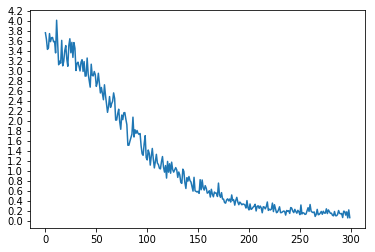

In [24]:
hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
    1, dropout_p=0.1)

trainIters(encoder1, attn_decoder1, 30000, print_every=1000, plot_every=100)

In [191]:
# checkpoint = torch.load("chatbot_1.tar")
# encoder1.load_state_dict(checkpoint['en'])
# attn_decoder1.load_state_dict(checkpoint['de'])

In [ ]:
# trainIters(encoder1, attn_decoder1, 30000, print_every=1000, plot_every=100)

In [26]:
# torch.save({
#     'en': encoder1.state_dict(),
#     'de': attn_decoder1.state_dict(),
# }, "chatbot_1.tar")

In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> merci beaucoup
= je vous en prie
< je vous en prie <EOS>

> est-ce un master en un an ?
= oui c est un m2 d un an
< oui c est un m2 d un an <EOS>

> il y a un stage a faire ?
= oui il y a un stage a faire
< oui il y a un stage a faire <EOS>

> combien d etudiants ont rate l an dernier ?
= un seul
< un seul <EOS>

> vous pouvez m aider ?
= oui volontier que desirez vous savoir ?
< oui je suis la pour vous renseigner <EOS>

> faut-il posseder son propre ordinateur ?
= non mais c est un confort vraiment tres pratique
< non mais c est un confort vraiment tres pratique <EOS>

> a combien s eleve la gratification durant le stage ?
= la paye minimale durant le stage est de 550 euros mensuels environ
< la paye minimale durant le stage est de 550 euros mensuels environ <EOS>

> comment sont les enseignants ?
= a vous de vous faire votre avis
< a vous de vous faire votre avis <EOS>

> si je viens de grenoble ?
= 5 places pour ceux qui ont un m1 francais
< 5 places pour ceux qui ont un m1 franc

New questions
=========

Ask new questions (never seen during training) using only the words that appear in your input vocabulary. 

In [27]:
mail="Bonjour, je suis intéressé par la data science. C'est quand la rentrée ?\
Quels sont les cours enseignés  ? Quelle est la durée du stage ?\
On peut faire un stage recherche en laboratoire ? Merci monsieur."

sentences = [s.strip() for s in re.split('[\.\,\?\!]' , mail)]
print(sentences[:-1])
sentences = sentences[:-1]

for sentence in sentences : #sentence.split() :
    sentence2= TrimWordsSentence(normalizeString(sentence))
    #print(sentence2)
    output_words, attentions = evaluate(encoder1, attn_decoder1, sentence2)
    output_sentence = ' '.join(output_words)
    print(sentence)
    #print('=', sentence2)
    print('->', output_sentence)
    print('')
    

['Bonjour', 'je suis intéressé par la data science', "C'est quand la rentrée", 'Quels sont les cours enseignés', 'Quelle est la durée du stage', 'On peut faire un stage recherche en laboratoire', 'Merci monsieur']
Bonjour
-> bonjour <EOS>

je suis intéressé par la data science
-> que faites-vous sur ecandidat <EOS>

C'est quand la rentrée
-> le 5 septembre <EOS>

Quels sont les cours enseignés
-> il faut regarder sur notre site web <EOS>

Quelle est la durée du stage
-> le mois doit avoir <EOS>

On peut faire un stage recherche en laboratoire
-> les stages sont effectues un stage seront transmises aux etudiants au fur et a mesure

Merci monsieur
-> de rien <EOS>



# Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

We simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:

For a better viewing experience we will do the extra work of adding axes
and labels:




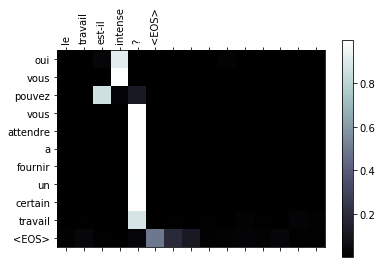

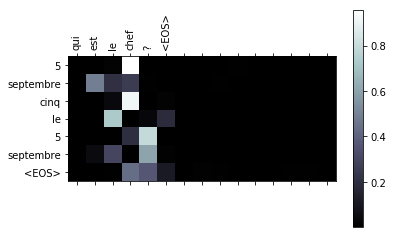

In [28]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention(TrimWordsSentence("le travail est-il intense ?"))
evaluateAndShowAttention(TrimWordsSentence("qui est le chef ?"))

---
# TO DO



-  Discuss the weaknesses of this simple approach
-  Allow words in the new questions that were unseen during training.
-  Allow questions of > 10 words (for instance, by selecting 10 words at random in the sentence).
-  Adapt the code to handle several sequences at once (like an email)
-  Replace the embeddings with pre-trained word embeddings such as word2vec (or GloVe).
-  Try with more layers, more/less hidden units, and more sentences. Compare
   the training time and performance.
-  Define and plot other loss functions for this specific task (e.g. % correct words)


# Further ideas (optional)
- Use "negative sampling", i.e. sampling random words to form incorrect questions (answering the question with something like 'I don't understand your question, sorry.' in order to enforce the model recognize a questions that are not syntactically (and semantically) correct. 
The probability for selecting a word as a negative sample should be related to its frequency, with more frequent words being more likely to be selected as negative samples. 
- To reduce the size of the input vocabulary and thus the computational burden, try to replace all the unknwon words with an unknown token <UNK> instead of ignoring them.
-  Adapt the decoder to infer directly the word embeddings (semantic) in the output sentence.  



## Discuss the weaknesses of this simple approach

N'étant pas (encore) très expérimenté en chatbot ou même en réseau de neurones, les idées suggérées sont issues du tutorial PyTorch sur le ChatBot.

Amélioration des performances :
- Le réseau de neurones est actuellement unidirectionnel. Il serait intéressant d'en implémenter un autre en sens inverse pour effectuer un traitement bidirectionnel. De cette manière, le chatbot serait à même d'encoder indépendamment d'une part le contexte passé et d'autre part le contexte futur.
- Ignorer les mots rares et/ou les mots courants.

Optimisation de l'entraînement : (essentiellement de la recherche du gradient descendant)
- Ajouter une technique de batching, c'est-à-dire de traitement des données par paquet. Actuellement, le réseau de neurones apprend donnée par donnée, ce qui peut bruiter le gradient lorsqu'il tombe sur un couple question/réponse bizarre. L'avantage de traiter plusieurs données par paquet est de lisser ce bruit et d'améliorer l'indication du gradient.
- Utiliser une technique dite de gradient clipping, qui consiste à plafonner le gradient pour éviter les problèmes aux abords de pentes "brutales".
https://pytorch.org/tutorials/_images/grad_clip.png

Utilisation :
- Sauvegarder le chatbot afin de pouvoir l'utiliser à nouveau sans devoir le réentraîner.

## Allow words in the new questions that were unseen during training.

On modifie le codage d'une phrase en index dans la fonction **indexesFromSentence**.
Si le mot n'est pas trouvé, alors on l'ignore.

In [29]:
def indexesFromSentence(lang, sentence):
    indexes = []
    # Pour chaque mot,
    for word in sentence.split():
        # on le code uniquement si on le trouve dans le dictionnaire.
        if word in lang.word2index:
            indexes.append(lang.word2index[word])
    return indexes

Vérification.

In [30]:
def discuss(encoder1, attn_decoder1, message):
    message = normalizeString(message)
    output_words, attentions = evaluate(encoder1, attn_decoder1, message)
    output_sentence = ' '.join(output_words)
    print(message)
    print("-->", output_sentence)

In [31]:
message = "qui est ton dieu ?"
discuss(encoder1, attn_decoder1, message)

qui est ton dieu ?
--> c est mr aussem qui a developpe le chatbot <EOS>


In [32]:
message = "qui esst ton dieu ?"
discuss(encoder1, attn_decoder1, message)

qui esst ton dieu ?
--> c est mr aussem qui a developpe le chatbot <EOS>


## Allow questions of > 10 words (for instance, by selecting 10 words at random in the sentence).

On supprime des mots au hasard lorsque la phrase est trop longue.

In [33]:
message = "Les réseaux de neurones sont-ils abordés dans le parcours Data Science ? ? ? ? ? ? ? ? ?"

input_variable = variableFromSentence(input_lang, message)
print(input_variable)
print("La phrase d'origine est de longueur", len(input_variable))

# Si la taille de la phrase dépasse <MAX_LENGTH>,
if len(input_variable) >= MAX_LENGTH:
    # on sélectionne <max_length> mots à garder.
    selection = random.sample(range(len(input_variable)), MAX_LENGTH)
    
    input_variable = input_variable[sorted(selection)]

print(input_variable)
print("La phrase tronquée est de longueur", len(input_variable))

tensor([[  6],
        [571],
        [ 21],
        [111],
        [ 29],
        [ 82],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [  1]])
La phrase d'origine est de longueur 16
tensor([[  6],
        [ 21],
        [111],
        [ 29],
        [ 82],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [ 10],
        [  1]])
La phrase tronquée est de longueur 15


On modifie la fonction **evaluate**.

In [34]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    
    # Si la taille de la phrase dépasse <max_length>,
    if len(input_variable) >= max_length:
        # on sélectionne <max_length> mots à garder.
        selection = random.sample(range(len(input_variable)), max_length)

        input_variable = input_variable[sorted(selection)]
    
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):

        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data

        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()

        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))

    return decoded_words, decoder_attentions[:di + 1]

On vérifie avec une question artificiellement rallongée.

In [35]:
discuss(encoder1, attn_decoder1, message)
discuss(encoder1, attn_decoder1, message)
discuss(encoder1, attn_decoder1, message)
discuss(encoder1, attn_decoder1, message)
discuss(encoder1, attn_decoder1, message)
discuss(encoder1, attn_decoder1, message)

les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> les reseaux de neurones sont abordes en machine learning notamment <EOS>
les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> le master ds du liris <EOS>
les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> les reseaux de neurones sont abordes en machine learning notamment <EOS>
les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> non <EOS>
les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> les reseaux de neurones sont abordes en machine learning notamment <EOS>
les reseaux de neurones sont-ils abordes dans le parcours data science ? ? ? ? ? ? ? ? ?
--> les reseaux de neurones sont abordes en machine learning notamment <EOS>


On observe que la réponse peut être très différente suivant les mots (aléatoirement) retenus par le chatbot.

## Adapt the code to handle several sequences at once (like an email)

On reprend l'exemple proposé.

In [36]:
def mail_discuss(mail):
    sentences = [s.strip() for s in re.split('[\.\,\?\!]' , mail)]
    sentences = sentences[:-1]

    for sentence in sentences : #sentence.split() :
        sentence2= TrimWordsSentence(normalizeString(sentence))
        output_words, attentions = evaluate(encoder1, attn_decoder1, sentence2)
        output_sentence = ' '.join(output_words)
        print(sentence)
        print('->', output_sentence)
        print('')
        
mail="Bonjour, je suis intéressé par la data science. C'est quand la rentrée ?\
Quels sont les cours enseignés ? Quelle est la durée du stage ?\
On peut faire un stage recherche en laboratoire ? Merci monsieur."

mail_discuss(mail)

Bonjour
-> bonjour <EOS>

je suis intéressé par la data science
-> que faites-vous sur ce site web du master <EOS>

C'est quand la rentrée
-> le 5 septembre <EOS>

Quels sont les cours enseignés
-> il faut regarder sur notre site web <EOS>

Quelle est la durée du stage
-> le stage doit avoir <EOS>

On peut faire un stage recherche en laboratoire
-> les stages sont effectues un stage seront transmises aux etudiants au fur et a mesure

Merci monsieur
-> de rien <EOS>



## Implémenter un enregistrement du chatbot.

Sauvegarde.

In [37]:
# torch.save({
#     'en': encoder1.state_dict(),
#     'de': attn_decoder1.state_dict(),
# #     'en_opt': encoder_optimizer.state_dict(),
# #     'de_opt': decoder_optimizer.state_dict(),
# }, "checkpoint.tar")

Chargement.

In [38]:
# # Réinitialisation du chat bot.
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size)

# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
#     1, dropout_p=0.1)

# checkpoint = torch.load("checkpoint.tar")
# encoder1.load_state_dict(checkpoint['en'])
# attn_decoder1.load_state_dict(checkpoint['de'])

On vérifie que le chargement a bien été effectué.

In [39]:
# evaluateRandomly(encoder1, attn_decoder1)

## Replace the embeddings with pre-trained word embeddings such as word2vec (or GloVe).

### On implémente un modèle *Word2Vec* que l'on entraîne avec le dataset du chatbot.

In [40]:
# On importe <gensim>, la bibliothèque de <word2vec>.
from gensim.models import Word2Vec

# Pour chaque paire, on sélectionne chaque mot dans la question et chaque mot dans la réponse.
vocabulary = [word for pair in pairs for word in pair[0].split(" ") + pair[1].split(" ")]

# On crée le modèle.
vocab_dim = 100
model = Word2Vec(size=vocab_dim, window=5, min_count=1, workers=4)
# On lui indique son vocabulaire. (Ce qu'il doit coder.)
model.build_vocab([vocabulary])
print(set(list(model.wv.vocab)[:10]))

{'de', 'puis-je', 'l', 'python', 'reviser', '?', 'avant', 'annee', 'commencer', 'que'}


In [41]:
# On récupère les phrases.
sentences = [sentence.split(" ") for pair in pairs for sentence in pair]
print(sentences[:10])

[['que', 'puis-je', 'reviser', 'avant', 'de', 'commencer', 'l', 'annee', '?'], ['python', 'statistiques', 'console', 'linux'], ['quels', 'sont', 'les', 'prerequis', '?'], ['python', 'statistiques', 'console', 'linux'], ['que', 'puis-je', 'travailler', 'avant', 'de', 'commencer', 'l', 'annee', '?'], ['python', 'statistiques', 'console', 'linux'], ['que', 'puis-je', 'reviser', 'avant', 'de', 'commencer', 'les', 'cours', '?'], ['python', 'statistiques', 'console', 'linux'], ['que', 'puis-je', 'travailler', 'avant', 'de', 'commencer', 'les', 'cours', '?'], ['python', 'statistiques', 'console', 'linux']]


In [42]:
# iterations = 100

# # On entraîne le modèle.
# for i in range(iterations):
#     print("Étape :", i+1, "sur", iterations)
#     model.train(sentences, total_examples=len(sentences), epochs=len(sentences))

On teste le modèle obtenu.

In [43]:
model.wv.most_similar(positive="un", topn=5)

[('pourriez', 0.4198285639286041),
 ('connaitre', 0.32055479288101196),
 ('pourquoi', 0.290120393037796),
 ('proportion', 0.287329763174057),
 ('face', 0.27665314078330994)]

Juste pour le fun. :)

In [44]:
model.wv.most_similar(positive="aussem", topn=5)

[('etes', 0.3039303123950958),
 ('dieu', 0.29482322931289673),
 ('ete', 0.2926945090293884),
 ('etes-vous', 0.27368682622909546),
 ('mon', 0.24563688039779663)]

On enregistre le modèle.

In [45]:
# model.save("w2v/simple_model_.bin")

On charge le modèle et on vérifie que l'on retrouve les même résultats.

In [142]:
# On charge le modèle et on vérifie que l'on obtient les même résultats que précédemment.
model = Word2Vec.load("w2v/simple_model_save.bin")

In [143]:
model.wv.most_similar(positive="un", topn=5)

[('autres', 0.3705228567123413),
 ('parler', 0.29418501257896423),
 ('faite', 0.2899881899356842),
 ('venez', 0.28522273898124695),
 ('le', 0.28428155183792114)]

In [144]:
model.wv.most_similar(positive="aussem", topn=5)

[('preferable', 0.4511116147041321),
 ('gentil', 0.4288483262062073),
 ('co-responsable', 0.42609983682632446),
 ('developpe', 0.4152342677116394),
 ('alexandre', 0.40354400873184204)]

###  On intègre ce modèle *Word2Vec* dans le chatbot.

On fusionne les deux langue d'entrée et de sortie en une seule.
<br>
- Chaque mot est associé à un index, via our_lang.
- Chaque index est associé à un vecteur, via embedding_weights.

In [46]:
# On fusionne les deux langues d'entrée et de sortie dans une seule.
our_lang = Lang("questions/réponses")
for word in model.wv.vocab:
    our_lang.addWord(word)

In [47]:
# <our_lang> :           mot    -->  index
# <embedding_weights> :  index  -->  vecteur

n_symbols = our_lang.n_words + 1
embedding_weights = np.zeros((n_symbols, vocab_dim))
for word,index in our_lang.word2index.items():
    try:
        embedding_weights[index, :] = model.wv[word]
    except KeyError:
        pass
hidden_size = embedding_weights.shape[1]

On vérifie sur le mot "aussem" que les associations sont exactes.

In [48]:
print(our_lang.word2index["aussem"])
print(embedding_weights[our_lang.word2index["aussem"]] == model.wv["aussem"])

649
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


Oui, les vecteurs du modèle et des poids envoyés sont les mêmes et l'index est 649.

In [49]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split()]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(our_lang, pair[0])
    target_variable = variableFromSentence(our_lang, pair[1])
    return (input_variable, target_variable)

In [50]:
# On définit deux nouvelles classes d'encodeur et de décodeur
    # pouvant être initialisés avec un encodage de mots prédéfinis.

class EncoderRNN_with_trained_embedding(nn.Module):
    def __init__(self, input_size, hidden_size, pretrained_embed, n_layers=1):
        super(EncoderRNN_with_trained_embedding, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # Initialise l'encodage du réseau de neurones sur celui pré-entraîné passé en paramètre.
        self.embedding = nn.Embedding(input_size, hidden_size)
        pretrained_embed = torch.Tensor(pretrained_embed)
        self.embedding.weight = nn.Parameter(pretrained_embed)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

class AttnDecoderRNN_with_trained_embedding(nn.Module):
    def __init__(self, hidden_size, output_size, pretrained_embed, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_with_trained_embedding, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Initialise l'encodage du réseau de neurones sur celui pré-entraîné passé en paramètre.
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        pretrained_embed = torch.Tensor(pretrained_embed)
        self.embedding.weight = nn.Parameter(pretrained_embed)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result

In [51]:
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
#     print('')
#     print("input_variable ==>", input_variable)
#     print("target_variable ==>", target_variable)
#     print("use_teacher_forcing ==>", use_teacher_forcing)
#     print("decoder_input ==>", decoder_input)
#     print("decoder_hidden ==>", decoder_hidden)
#     print("encoder_outputs ==>", encoder_outputs)

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            #decoder_output, decoder_hidden = decoder(
             #   decoder_input, decoder_hidden)       
            
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [53]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder1.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=learning_rate)
    
    training_pairs = [variablesFromPair(random.choice(pairs))
        for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [54]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(our_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        
        #decoder_output, decoder_hidden = decoder(
         #   decoder_input, decoder_hidden)

        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data

        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0].item()

        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(our_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))

    return decoded_words, decoder_attentions[:di + 1]

In [55]:
encoder1 = EncoderRNN_with_trained_embedding(n_symbols, hidden_size, embedding_weights)
attn_decoder1 = AttnDecoderRNN_with_trained_embedding(hidden_size, n_symbols,
    embedding_weights,1, dropout_p=0.1)

0m 25s (- 12m 24s) (1000 3%) 3.6593
0m 51s (- 12m 5s) (2000 6%) 3.6034
1m 14s (- 11m 6s) (3000 10%) 3.4933
1m 38s (- 10m 43s) (4000 13%) 3.3533
2m 4s (- 10m 23s) (5000 16%) 3.2583
2m 28s (- 9m 52s) (6000 20%) 3.3276
2m 52s (- 9m 26s) (7000 23%) 3.3163
3m 19s (- 9m 9s) (8000 26%) 3.2134
3m 46s (- 8m 47s) (9000 30%) 3.2610
4m 14s (- 8m 28s) (10000 33%) 3.2206
4m 41s (- 8m 6s) (11000 36%) 3.0969
5m 12s (- 7m 48s) (12000 40%) 3.1867
5m 44s (- 7m 29s) (13000 43%) 3.1135
6m 9s (- 7m 2s) (14000 46%) 3.2025
6m 35s (- 6m 35s) (15000 50%) 2.9324
7m 6s (- 6m 13s) (16000 53%) 2.9166
7m 39s (- 5m 51s) (17000 56%) 2.9544
8m 15s (- 5m 30s) (18000 60%) 3.0296
8m 44s (- 5m 3s) (19000 63%) 3.0558
9m 15s (- 4m 37s) (20000 66%) 2.9595
9m 51s (- 4m 13s) (21000 70%) 2.9070
10m 21s (- 3m 46s) (22000 73%) 2.8596
10m 50s (- 3m 17s) (23000 76%) 2.7725
11m 18s (- 2m 49s) (24000 80%) 2.7328
11m 45s (- 2m 21s) (25000 83%) 2.7118
12m 16s (- 1m 53s) (26000 86%) 2.7129
12m 48s (- 1m 25s) (27000 90%) 2.7002
13m 19s (-

<Figure size 432x288 with 0 Axes>

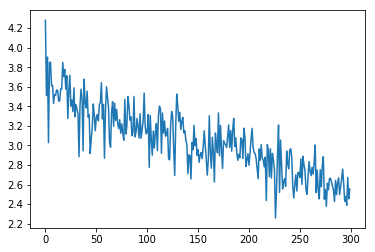

In [56]:
trainIters(encoder1, attn_decoder1, 30000, print_every=1000, plot_every=100)

Sauvegarde.

In [57]:
def save_chatbot(name):
    torch.save({
        'en': encoder1.state_dict(),
        'de': attn_decoder1.state_dict(),
    }, name)

Chargement.

In [58]:
def load_chatbot(name):
    # Réinitialisation du chat bot.
    encoder1 = EncoderRNN_with_trained_embedding(n_symbols, hidden_size, embedding_weights)
    attn_decoder1 = AttnDecoderRNN_with_trained_embedding(hidden_size, n_symbols,
        embedding_weights,1, dropout_p=0.1)

    checkpoint = torch.load(name)
    encoder1.load_state_dict(checkpoint['en'])
    attn_decoder1.load_state_dict(checkpoint['de'])

In [60]:
save_chatbot("chatbot_2")
# load_chatbot("chatbot_2")

On vérifie que le chargement a été correctement effectué.

In [61]:
evaluateRandomly(encoder1, attn_decoder1)

> quelles sont les horaires ?
= cela depend des jours voir la page planning
< il y a 10 places pour les etudiants etrangers <EOS>

> je suis deja en france ?
= dans ce cas etes vous de lyon1 ?
< il est mr aussem qui a developpe le chatbot <EOS>

> il y a une difference entre le parcours info et math ?
= le contenu est le meme seules les ue de remise a niveau sont differentes
< oui est a neurones sont un a un <EOS>

> quel est le niveau en anglais ?
= il faut obtenir le niveau b1 au toeic pour valider le master
< il est de vous scientist a master <EOS>

> combien d etages ont les batiments de cours ?
= les batiments ont 2 etages
< oui il y a un cours de machine learning <EOS>

> est-ce qu il y a un stage obligatoire en fin d annee ?
= oui de six mois a partir de mars
< oui est a neurones sont un a un <EOS>

> je souhaite postuler
= les inscriptions 2018 se font sur ecandidat
< merci j en prends note <EOS>

> faut il parler anglais ?
= le niveau b2 du toeic est requis pour valider le mas

### On charge un encodage w2v pré-entraîné.

- On utilise un encodage w2v pré-entraîné sur un corpus de 1,6 billion de mots hébergé sur le site *http://wacky.sslmit.unibo.it*.
- L'entraînement est de type CBOW pour Common Bag Of Words, c'est-à-dire que l'on considère les mots par ensemble.
- La dimension de l'espace vectoriel associé est 500, c'est-à-dire que les mots sont associés à des vecteurs de taille 500.
- Le cutoff est de 100, c'est-à-dire que l'on néglige les mots n'apparaissant pas au moins 100 fois dans le corpus.



In [62]:
from gensim.models import KeyedVectors
filename = "w2v/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
model = KeyedVectors.load_word2vec_format(filename, binary=True)

On examine le pourcentage de mots communs entre our_lang et le word2vec importé.

In [63]:
words = list(model.vocab)
# print(set(our_lang.word2index).intersection(words))
l1 = len(list(set(our_lang.word2index).intersection(words)))
print('Percentage of common words w.r.t. input_lang : %0.2f%%' % (100 * l1/our_lang.n_words))
print('Percentage of common words w.r.t. word2vec vocab : %0.2f%%' % (100 * l1/len(words)))

Percentage of common words w.r.t. input_lang : 90.68%
Percentage of common words w.r.t. word2vec vocab : 0.58%


In [64]:
def indexesFromSentence(lang, sentence, verbose=False):
    indexes=[]
    # On examine tous les mots.
    for word in sentence.split():
        # S'il est dans le vocabulaire, c'est bon.
        if word in set(lang.word2index):
            if verbose: print("Mot trouvé dans le vocabulaire :",word)
            indexes.append(lang.word2index[word])
        # S'il n'est pas dans le vocabulaire, alors on cherche s'il existe sur Wikipédia.
        elif word in model.vocab:
            need_replacement = True
            i = 1
            # On cherche un mot similaire parmi les dix premiers
                # et présent dans le vocabulaire pour le remplacer.
            while need_replacement:
                new_word = model.most_similar(positive=[word], topn=i)[0][0]
                if new_word in set(lang.word2index):
                    indexes.append(lang.word2index[new_word])
                    need_replacement = False
                    if verbose:
                        print("Mot inconnu dans le vocabulaire :",word)
                        print("--> Remplacé par le mot Wikipédia :", new_word)
                i = i + 1
                if i >= 10:
                    break
            # Si on ne trouve rien de satisfaisant, on ne le remplace pas.
            if verbose:
                if need_replacement:
                    print("Mot inconnu dans le vocabulaire :",word)
                    print("--> Trouvé dans Wikipédia mais non remplacé")
        # Enfin, le mot peut-être inconnu du vocabulaire et de Wikipédia.
        else:
            if verbose:
                print("Mot inconnu dans le vocabulaire :",word)
                print("--> Inconnu sur Wikipédia",word)
    # Si la phrase est trop grande, alors on pioche au hasard <MAX_LENGTH> mots.
    while len(indexes) >= MAX_LENGTH:
        indexes.pop(random.randint(1,len(indexes)-2))
    return indexes

def sentenceFromIndexes(lang, indexes):
    sentence = []
    for i in indexes:
        sentence.append(lang.index2word[i])
    sentence = ' '.join(sentence)
    return sentence

On vérifie sur une phrase.

In [65]:
new_sentence = "Faire du thé Wulong est simple."
trimmed_sentence = TrimWordsSentence(normalizeString(new_sentence))
indexes = indexesFromSentence(our_lang, trimmed_sentence, verbose=True)
print("")
print('Phrase originale')
print('-->', trimmed_sentence)
print('Mots inclus dans our_lang')
print('-->', sentenceFromIndexes(our_lang, indexes))

Mot trouvé dans le vocabulaire : faire
Mot trouvé dans le vocabulaire : du
Mot inconnu dans le vocabulaire : the
--> Trouvé dans Wikipédia mais non remplacé
Mot inconnu dans le vocabulaire : wulong
--> Inconnu sur Wikipédia wulong
Mot trouvé dans le vocabulaire : est
Mot inconnu dans le vocabulaire : simple
--> Remplacé par le mot Wikipédia : facile

Phrase originale
--> faire du the wulong est simple
Mots inclus dans our_lang
--> faire du est facile


Trois mots sont inconnus dans le vocabulaire : **Thé**, **Wulong** et **Simple**.

- **Wulong** est aussi inconnu dans Wikipédia (écarté par cutoff), donc on l'ignore.
- **Thé** est connu dans Wikipédia mais on ne trouve pas de mots similaires dans le vocabulaire. (Cohérent car celui-ci est issu d'un questionnaire sur le Master et non sur des discussions d'un salon de thé.)
- **Simple** est connu dans Wikipédia et remplacé par le mot similaire **facile** trouvé dans le vocabulaire.

In [69]:
encoder1 = EncoderRNN_with_trained_embedding(n_symbols, hidden_size, embedding_weights)
attn_decoder1 = AttnDecoderRNN_with_trained_embedding(hidden_size, n_symbols,
    embedding_weights,1, dropout_p=0.1)

0m 33s (- 16m 12s) (1000 3%) 3.5076
0m 58s (- 13m 39s) (2000 6%) 3.6275
1m 19s (- 11m 52s) (3000 10%) 3.4237
1m 39s (- 10m 49s) (4000 13%) 3.3963
2m 1s (- 10m 7s) (5000 16%) 3.3587
2m 22s (- 9m 30s) (6000 20%) 3.3546
2m 43s (- 8m 57s) (7000 23%) 3.1416
3m 4s (- 8m 27s) (8000 26%) 3.2376
3m 25s (- 8m 0s) (9000 30%) 3.1857
3m 46s (- 7m 33s) (10000 33%) 3.0377
4m 8s (- 7m 8s) (11000 36%) 3.1444
4m 29s (- 6m 43s) (12000 40%) 2.9983
4m 51s (- 6m 21s) (13000 43%) 3.1681
5m 13s (- 5m 58s) (14000 46%) 3.0130
5m 35s (- 5m 35s) (15000 50%) 3.0329
5m 58s (- 5m 13s) (16000 53%) 3.1063
6m 20s (- 4m 50s) (17000 56%) 2.9543
6m 42s (- 4m 28s) (18000 60%) 2.9557
7m 4s (- 4m 6s) (19000 63%) 3.0075
7m 28s (- 3m 44s) (20000 66%) 3.0023
7m 50s (- 3m 21s) (21000 70%) 2.8739
8m 13s (- 2m 59s) (22000 73%) 2.7238
8m 35s (- 2m 36s) (23000 76%) 2.6794
8m 57s (- 2m 14s) (24000 80%) 2.6480
9m 20s (- 1m 52s) (25000 83%) 2.5757
9m 42s (- 1m 29s) (26000 86%) 2.5658
10m 4s (- 1m 7s) (27000 90%) 2.4410
10m 28s (- 0m 44

<Figure size 432x288 with 0 Axes>

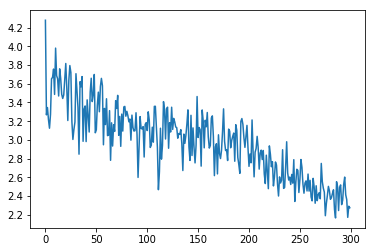

In [70]:
trainIters(encoder1, attn_decoder1, 30000, print_every=1000, plot_every=100)

In [71]:
evaluateRandomly(encoder1, attn_decoder1)

> quelles sont les horaires ?
= cela depend des jours voir la page planning
< le stage est plutot bon <EOS>

> et les credits par matiere ?
= developpement informatique vaut 6 credits et le stage vaut 21 credits
< non mais c est un <EOS>

> je ne vois pas de module de deep learning dans le programme du master
= les reseaux de neurones sont abordes en machine learning notamment
< il faut en presentation plusieurs projets en ue de l inscription <EOS>

> qui est le referent pour les ds maths ?
= gabriela ciuperca
< il faut mr un master <EOS>

> y-aura t-il une ceremonie de remise des diplome ?
= oui bien-sur
< oui il y a 2 cours de machine learning <EOS>

> sommes-nous facilement recruter a la sortie du master ?
= oui
< oui <EOS>

> est-ce que les projets concernent plusieurs ue ?
= non les projets concernent chacun une seule ue
< non mais c est un confort vraiment tres pratique <EOS>

> le master dure 2 ans ?
= non c est un m2 d un an
< non mais c est un <EOS>

> quelle date de rentree ?